In [1]:
import schemdraw
from schemdraw.flow import *
from PyPDF2 import PdfReader, PdfWriter
from os import listdir
from numpy import array

# Choose colour scheme.
lgreen,     blue,      orng,      blk,     yel,       grn,       gry = \
'#C5E0B5', '#8FABDD', '#ED7D31', 'black', '#FDD865', '#91D04E', '#ECECEC'
# Set sizes.
width, node_wdth, char_ht, lw, bw,  arr_l = \
8.5,   4.5,       .5,      1,  0.5, 0.5

arr_kwargs = { # Keyword arguments for Arrow objects.
    'lw': lw, 'headlength': .15
}

# Number of univariate and multivariate inputs.
n_uv, n_mv = 49, 70

def crop(file, crop_w=20, crop_h=20):
    '''Take a PDF file name and crop the document.'''
    # Open PDF and get the first (presumably only) page.
    reader = PdfReader(file)
    page = reader.pages[0]
    # Set the crop width and height as a tuple and crop the PDF.
    crop_dims = (crop_w, crop_h)
    page.mediabox.lower_left = crop_dims
    page.mediabox.upper_right = tuple([
        float(e) - crop_dims[i] 
        for i, e in enumerate(page.cropbox.upper_right)
    ])

    # Write the cropped PDF over the original document.
    writer = PdfWriter()
    writer.add_page(page)
    with open(file,'wb') as f:
        writer.write(f) 

# Define the pathway for the figure and table outputs.
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip()
else:
    fig_dir = 'Figures/'
    

In [2]:
actv_len = 0.3 # Activation function length.
relu_offset = [1, .35] # Offset to draw relu function.
relu_y = array([0, actv_len*2, actv_len]) # Moves to relu line end.
id_start = array([1, .25]) # Starting point for identity activation.
# End point for identity activation.
id_end = id_start + array([actv_len*2, actv_len*1.5])

def MLP(
    d, input_size, output='$\\hat\\boldsymbol{y}_{n=2}$', 
    hidden=1
):
    '''Take a drawing object and draw an MLP of abritrary depth.'''

    # Draw the input layer and arrow coming from it.
    d += (Inp := Circle(r=char_ht, color='white').label(
        f'$\\boldsymbol{{X}}_{{n={input_size}}}$', color=blk
    ))
    d += Arrow(**arr_kwargs).down(arr_l).at(Inp.S)

    prev = Inp
    # For index of hidden layers...
    for i in range(hidden):

        # Draw the hidden layer.
        d += (prev := Process(node_wdth, 1, fill=gry, lw=bw).label(
            r'$\mathbf{FC\;layer}_\text{32 units}$', 
            fontsize=12, color=blk, ofst=(-.5, 0)
        ))
        # Draw an identity activation half the time.
        if i % 2 != 0:
            d.move(*id_start)
            d += Line().to(*array([prev.S, *id_end], dtype=object))
        # Draw a relu activation half the time.
        else:
            l1 = array([prev.S, *relu_offset], dtype=object)
            d += Line().right(actv_len).at(*l1)
            d += Line().to(*l1 + relu_y)
            
        # Draw the arrow to the next node.
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)

    # If only one output is listed...
    if type(output) == str:
        # Draw the output layer.
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)
        d += (
            y_hat := Circle(r=char_ht, color='white')\
                .label(output, color=blk)
        )
    # If multiple outputs are listed...
    else:
        # Space out and draw multiple outputs.
        d += Line(lw=lw).down(arr_l).at(prev.S)
        n_spaces, space_w = len(output) - 1, 1.5
        
        d.move(n_spaces * space_w / 2, 0)
        d += Line(lw=lw).left(n_spaces * space_w)
        for out in output:
            d += Arrow(**arr_kwargs).down(arr_l)
            d += (
                y_hat := Circle(r=char_ht, color='white')
                    .label(out, color=blk)
            )
            d.move_from(y_hat.N, space_w, arr_l)

    # Draw the identity activation of the output layer.
    d.move(*id_start)
    d += Line().to(*array([y_hat.S, *id_end], dtype=object))

    # Move pointer in position for next MLP diagram.
    d.move_from(Inp.E, node_wdth, char_ht-.85)


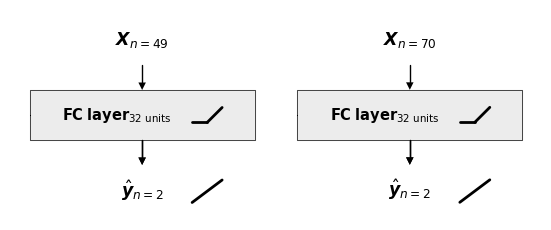

In [3]:
# Draw the shallow MLPs.
with schemdraw.Drawing(
    file=f'{fig_dir}/Diagrams/MLP Shallow.pdf', dpi=150
) as d:

    # Draw univariate model.
    MLP(d, n_uv)
    # Draw multivariate model.
    MLP(d, n_mv)

crop(d.outfile, 5, 15) 


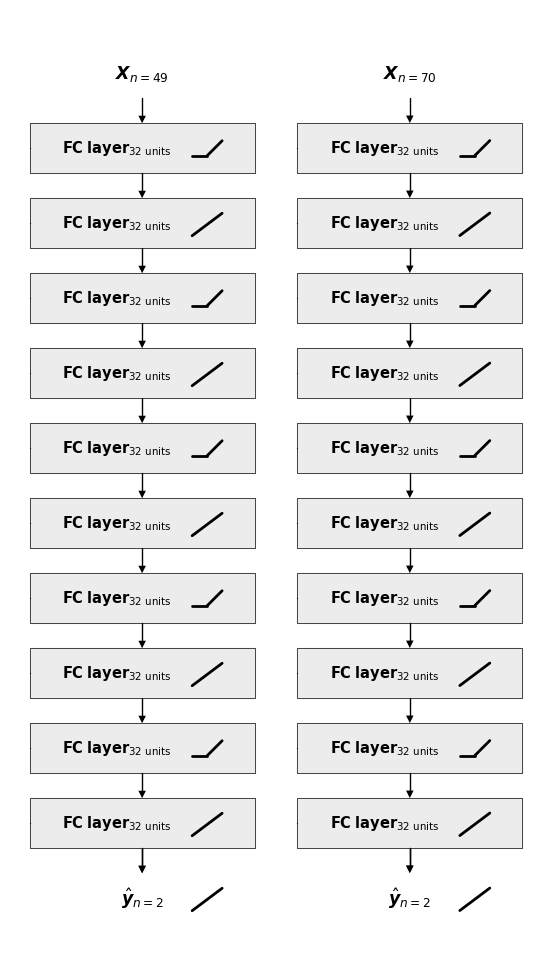

In [4]:
# Draw the deep MLPs.
with schemdraw.Drawing(
    file=f'{fig_dir}/Diagrams/MLP Deep.pdf', dpi=150
) as d:
    
    # Draw univariate model.
    MLP(d, n_uv, hidden=10)
    # Draw multivariate model.
    MLP(d, n_mv, hidden=10)

crop(d.outfile, 5, 40) 


In [5]:
def BDLSTM(
    d, input_size, output='$\\hat\\boldsymbol{y}_{n=2}$', hidden=1
):
    '''Take a drawing object and draw a BD-LSTM of abritrary depth.'''

    k = 3.5 # Arc curvature parameter.

    # Draw the input layer.
    d += (Inp := Circle(r=char_ht, color='white').label(f'$\\boldsymbol{{X}}_{{n={input_size}}}$', color=blk))
    prev, prev2 = Inp, None

    # For each hidden layer...
    for i in range(hidden):
        # Draw arrow from the previous to the forward layer.
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)
        # Draw the forward layer.
        d += (
            For := Process(node_wdth, 1, fill=gry, lw=bw).label(
f'$\\mathbf{{Forward}}_\\text{{{2**(4+hidden-i)} units}}$\ttanh', 
                fontsize=12, color=blk, ofst=(-.25, 0)
            )
        )
        d.move_from(For.S, 0, -arr_l)

        # Draw the backward layer.
        d += (
            Back := Process(node_wdth, 1, fill=gry, lw=bw).label(
f'$\\mathbf{{Backward}}_\\text{{{2**(4+hidden-i)} units}}$\ttanh', 
                fontsize=12, color=blk, ofst=(-.25, 0)
            )
        )

        # Draw the arrow from the previous to the backward layer.
        d += Arc2(k=k, arrow='>', **arr_kwargs).to(Back.N).at(prev.S)
        d += Arrow(**arr_kwargs).down(arr_l).at(Back.S)

        # If this is not the first hidden layer...
        if prev2:
            # Draw a line from the previous to the forward layer.
            d += Arc2(k=-k, arrow='>', **arr_kwargs).to(For.N).at(prev2.S)
        prev, prev2 = Back, For # Update previous layers.



    # If only one output is listed...
    if type(output) == str:
        # Draw the output layer.
        d += Arrow(**arr_kwargs).down(arr_l).at(prev.S)
        d += (
            y_hat := Circle(r=char_ht, color='white')\
                .label(output, color=blk)
        )
        
    # If multiple outputs are listed...
    else:
        # Space out and draw multiple outputs.
        d += Line(lw=lw).down(arr_l).at(prev.S)
        n_spaces, space_w = len(output) - 1, 1.5
        
        d.move(n_spaces * space_w / 2, 0)
        d += Line(lw=lw).left(n_spaces * space_w)
        for out in output:
            d += Arrow(**arr_kwargs).down(arr_l)
            d += (
                y_hat := Circle(r=char_ht, color='white')\
                    .label(out, color=blk)
            )
            d.move_from(y_hat.N, space_w, arr_l)

    # Draw the final line from the previous to the forward layer.
    d += Arc2(k=-k, arrow='>', **arr_kwargs).to(y_hat.N).at(For.S)
    
    # Draw the identity activation of the output layer.
    ofst = array([0, -1])
    d.move(*id_start + ofst)
    d += Line().to(*array([y_hat.N, *id_end + ofst], dtype=object))

    # Move pointer in position for next BD-LSTM diagram.
    d.move_from(Inp.E, node_wdth*1.5, char_ht-.8535)


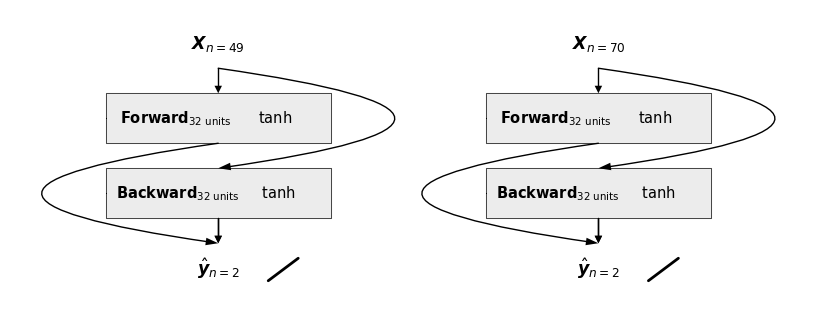

In [6]:
# Draw the shallow BD-LSTM.
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/BD-LSTM Shallow.pdf', dpi=150) as d:

    # Draw univariate model.
    BDLSTM(d, n_uv)
    # Draw multivariate model.
    BDLSTM(d, n_mv)

crop(d.outfile, 8, 18) 


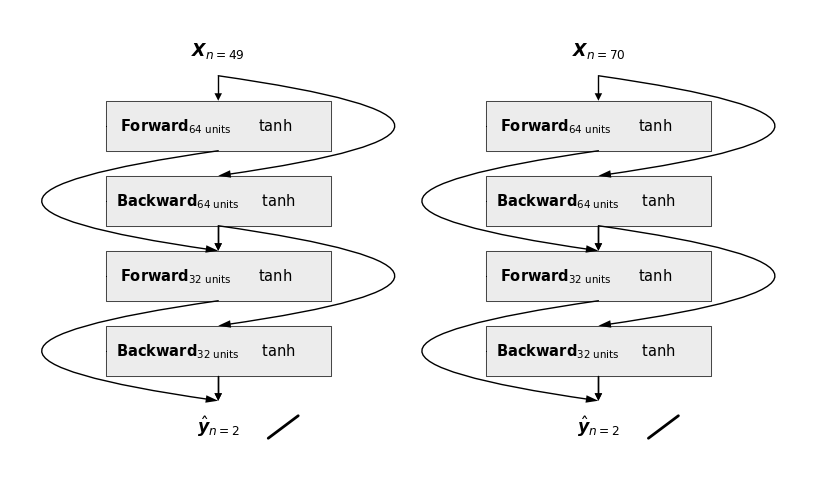

In [7]:
# Draw the deep BD-LSTM.
with schemdraw.Drawing(file=f'{fig_dir}/Diagrams/BD-LSTM Deep.pdf', dpi=150) as d:

    # Draw univariate model.
    BDLSTM(d, n_uv, hidden=2)
    # Draw multivariate model.
    BDLSTM(d, n_mv, hidden=2)

crop(d.outfile, 8, 25) 


In [8]:
def CNN1D(d, output='$\\hat\\boldsymbol{y}$'):
    '''Take a drawing object and draw a 1D-CNN of abritrary depth.'''

    # Draw the left input layer and arrow.
    d += (L := Circle(char_ht, color='white').label(r'$L$', color=blk))
    d += Arrow(**arr_kwargs).down(arr_l).at(L.S)

    # Draw the left convolutional layer and arrow.
    d += (
        conv42 := RoundProcess(node_wdth, 1, fill=lgreen, color=lgreen)\
            .label('Conv1D (k=4, d=2)', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(conv42.S)

    # Draw the second left convolutional layer and arrow.
    d += (
        conv34 := RoundProcess(node_wdth, 1, fill=blue, color=blue)\
            .label('Conv1D (k=3, d=4)', fontsize=12, color=blk)
    )
    d += Line(lw=lw).down(2).at(conv34.S)
    d += Arrow(**arr_kwargs).right(3)

    d.move_from(L.E, width, 0)

    # Draw the right input layer.
    d += (
        TH := Circle(char_ht, color='white')\
            .label(r'$\left[T,H\right]$', color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(TH.S)

    # Draw the right convolutional layer and arrow.
    d += (
        conv42 := RoundProcess(node_wdth, 1, fill=lgreen, color=lgreen)\
            .label('Conv1D (k=4, d=2)', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(conv42.S)

    # Draw the second right convolutional layer and arrow.
    d += (
        conv34 := RoundProcess(node_wdth, 1, fill=blue, color=blue)\
            .label('Conv1D (k=3, d=4)', fontsize=12, color=blk)
    )
    d += Line(lw=lw).down(2).at(conv34.S)
    d += Arrow(**arr_kwargs).left(3)

    # Draw the concatenation layer.
    d += (
        conc := Process(node_wdth, 1, fill=orng, lw=bw)\
            .label('Concatenation', fontsize=12, color=blk)
    )

    # Draw the middle input layer and arrow.
    d.move_from(conc.N, .5, char_ht*3)
    d += (
        D := Circle(char_ht, color='white')\
            .label(r'$\boldsymbol{D}$', color=blk)
    )
    d += Arrow(**arr_kwargs).down(char_ht*2).at(D.S)
    
    d += Arrow(**arr_kwargs).down(arr_l).at(conc.S)

    # Draw the first residual multiplicative block.
    d += (
        RMB1 := RoundProcess(node_wdth, 1.5, fill=yel, lw=bw)\
            .label(r'$\mathbf{RMB}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(RMB1.S)

    # Draw the second residual multiplicative block.
    d += (
        RMB2 := RoundProcess(node_wdth, 1.5, fill=yel, lw=bw)\
            .label(r'$\mathbf{RMB}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(RMB2.S)

    # Draw the multiplicative unit.
    d += (
        MU := Process(node_wdth, 1.5, fill=grn, lw=bw)\
            .label(r'$\mathbf{MU}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(MU.S)

    # Draw the max pooling layer.
    d += (
        MaxP := Process(node_wdth, 1, fill=gry, lw=bw)\
            .label(r'$\mathbf{MaxPool\;1D}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(MaxP.S)

    # Draw the flatten layer.
    d += (
        Flat := Process(node_wdth, 1, fill=gry, lw=bw)\
            .label(r'$\mathbf{Flatten}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(Flat.S)

    # Draw the dropout layer.
    d += (
        Drop := Process(node_wdth, 1, fill=gry, lw=bw)\
            .label(r'$\mathbf{Dropout}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(Drop.S)

    # Draw the first dense layer.
    d += (
        FC1 := Process(node_wdth, 1, fill=gry, lw=bw)\
            .label(r'$\mathbf{FC\;Layer}$', fontsize=12, color=blk)
    )
    d += Arrow(**arr_kwargs).down(arr_l).at(FC1.S)

    # Draw the second dense layer.
    d += (
        FC2 := Process(node_wdth, 1, fill=gry, lw=bw)\
            .label(r'$\mathbf{FC\;Layer}$', fontsize=12, color=blk)
    )

    # If only one output is listed...
    if type(output) == str:
        # Draw the output layer.
        d += Arrow(**arr_kwargs).down(arr_l).at(FC2.S)
        d += (
            y_hat := Circle(char_ht, color='white')\
                .label(output, color=blk)
        )
    # If multiple outputs are listed...
    else:
        # Space out and draw multiple outputs.
        d += Line(lw=lw).down(arr_l).at(FC2.S)
        n_spaces, space_w = len(output) - 1, 1.5
        
        d.move(n_spaces * space_w / 2, 0)
        d += Line(lw=lw).left(n_spaces * space_w)
        for out in output:
            d += Arrow(**arr_kwargs).down(arr_l)
            d += (
                y_hat := Circle(char_ht, color='white')\
                    .label(out, color=blk)
            )
            d.move_from(y_hat.N, space_w, arr_l)
            
    # Move pointer in position for next 1D-CNN diagram.
    d.move_from(TH.E, node_wdth, char_ht)


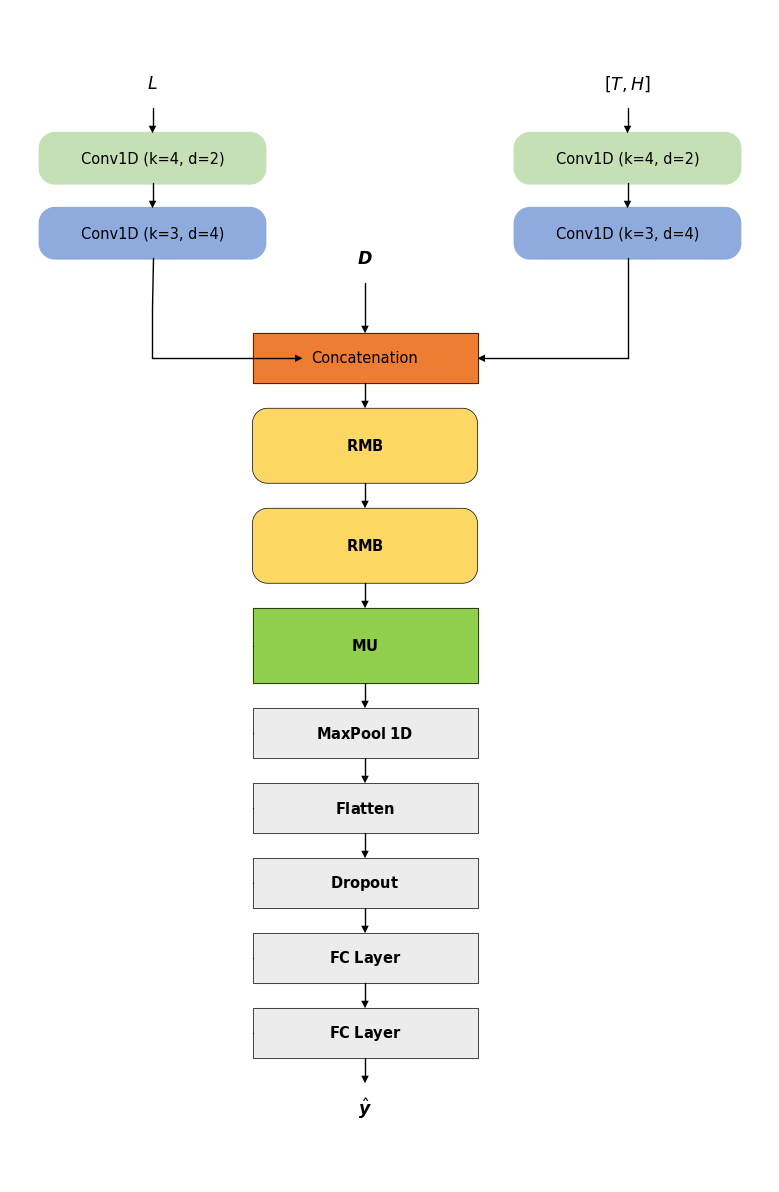

In [9]:
# Output labels
y_labs = [r'$\hat y_\text{1H}$', r'$\hat y_\text{24H}$']
# Draw the deep 1D-CNN.
with schemdraw.Drawing(
    file=f'{fig_dir}/Diagrams/1D-CNN.pdf', dpi=150
) as d:

    CNN1D(d)

crop(d.outfile, 15, 45) 

